In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf

In [14]:
df = pd.read_csv('beetroot .csv')
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.rstrip()

print(len(df))
df.head()

745


,Date,arrival(kg),Variety,minimum price/kg,maximum price/kg,modal price/kg,rain,season
0,01-01-2022,17000,Beetroot,55.0,60,57,0.0,8
1,03-01-2022,17000,Beetroot,75.0,80,77,0.0,8
2,04-01-2022,8000,Beetroot,73.0,80,76,0.0,8
3,05-01-2022,13000,Beetroot,70.0,75,72,3.0,8
4,06-01-2022,16000,Beetroot,68.0,72,70,0.0,8


In [15]:
print(df.columns)

Index(['Date', 'arrival(kg)', 'Variety', 'minimum price/kg',
       'maximum price/kg', 'modal price/kg', 'rain', 'season'],
      dtype='object')


In [16]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce', dayfirst=True)

# Check for any NaT values which indicate parsing issues
print(df['Date'].isna().sum())  # This will show how many dates couldn't be parsed

# If you have mixed formats, you can try parsing without specifying a format
# This will allow Pandas to infer the correct format for each date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)

# Display the DataFrame after conversion
print(df.head())

0
        Date  arrival(kg)   Variety  minimum price/kg  maximum price/kg  \
0 2022-01-01        17000  Beetroot              55.0                60   
1 2022-01-03        17000  Beetroot              75.0                80   
2 2022-01-04         8000  Beetroot              73.0                80   
3 2022-01-05        13000  Beetroot              70.0                75   
4 2022-01-06        16000  Beetroot              68.0                72   

   modal price/kg  rain  season  
0              57   0.0       8  
1              77   0.0       8  
2              76   0.0       8  
3              72   3.0       8  
4              70   0.0       8  


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Load your DataFrame (ensure this path is correct)
# df = pd.read_csv('your_file.csv')  # Uncomment and replace with your actual file path

# Clean column names if necessary
df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace

# Convert 'Date' column to datetime format and sort values
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Print available columns for debugging
print("Available columns:", df.columns)

# Define required features and check for their presence
required_features = ['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    required_features.append('rain')
if 'season' in df.columns:
    required_features.append('season')

# Select relevant features and drop rows with NaN values
df = df[required_features].dropna()

# One-hot encode the 'season' column if it exists
if 'season' in df.columns:
    encoder = OneHotEncoder(sparse_output=False)  # Updated argument here
    season_encoded = encoder.fit_transform(df[['season']])
    
    # Debugging: Print shape of encoded seasons
    print("Season encoded shape:", season_encoded.shape)
    
    # Combine encoded seasons with the DataFrame
    df_encoded = pd.concat([df.drop(columns=['season']), pd.DataFrame(season_encoded)], axis=1)
else:
    df_encoded = df.copy()  # No encoding needed if season is absent

# Normalize the numerical features
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_encoded[['minimum price/kg', 'maximum price/kg', 'modal price/kg'] + (['rain'] if 'rain' in df.columns else [])])

# Debugging: Print shape of scaled prices
print("Scaled prices shape:", scaled_prices.shape)

# Create a list of column names based on what was included in scaling
columns_list = ['minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    columns_list.append('rain')
if 'season' in df.columns:
    columns_list += list(encoder.get_feature_names_out())

# Debugging: Print expected columns count vs actual count
print("Expected columns count:", len(columns_list))
print("Actual scaled prices shape:", scaled_prices.shape[1])

# Create a DataFrame with scaled prices and encoded seasons (if any)
scaled_df = pd.DataFrame(scaled_prices, columns=columns_list[:scaled_prices.shape[1]])  # Adjust based on actual number of columns
scaled_df['Date'] = df['Date'].values[:scaled_df.shape[0]]  # Ensure Date aligns correctly

# Set Date as index
scaled_df.set_index('Date', inplace=True)

# Create sequences for LSTM input (X) and output (y)
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 2])  # Modal price is the target variable
    return np.array(X), np.array(y)

# Define time steps (number of previous days to consider)
time_steps = 30  # Using past 30 days to predict the next day

X, y = create_sequences(scaled_prices, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now X_train, X_test, y_train, and y_test are ready for model training and evaluation.

Available columns: Index(['Date', 'arrival(kg)', 'Variety', 'minimum price/kg',
       'maximum price/kg', 'modal price/kg', 'rain', 'season'],
      dtype='object')
Season encoded shape: (745, 11)
Scaled prices shape: (745, 4)
Expected columns count: 15
Actual scaled prices shape: 4


Available columns: Index(['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg',
       'rain', 'season'],
      dtype='object')


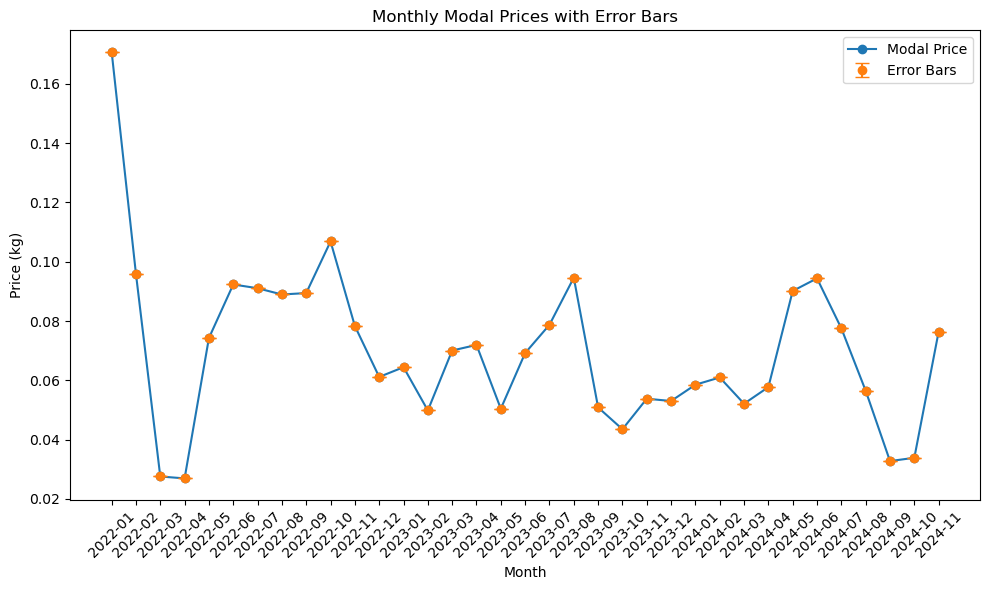

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Load your DataFrame (ensure this path is correct)
# df = pd.read_csv('your_file.csv')  # Uncomment and replace with your actual file path

# Clean column names if necessary
df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace

# Convert 'Date' column to datetime format and sort values
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Print available columns for debugging
print("Available columns:", df.columns)

# Define required features and check for their presence
required_features = ['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    required_features.append('rain')
if 'season' in df.columns:
    required_features.append('season')

# Select relevant features and drop rows with NaN values
df = df[required_features].dropna()

# One-hot encode the 'season' column if it exists
if 'season' in df.columns:
    encoder = OneHotEncoder(sparse_output=False)  # Updated argument here
    season_encoded = encoder.fit_transform(df[['season']])
    
    # Combine encoded seasons with the DataFrame
    df_encoded = pd.concat([df.drop(columns=['season']), pd.DataFrame(season_encoded)], axis=1)
else:
    df_encoded = df.copy()  # No encoding needed if season is absent

# Normalize the numerical features
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_encoded[['minimum price/kg', 'maximum price/kg', 'modal price/kg'] + (['rain'] if 'rain' in df.columns else [])])

# Create a DataFrame with scaled prices and encoded seasons (if any)
columns_list = ['minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    columns_list.append('rain')
if 'season' in df.columns:
    columns_list += list(encoder.get_feature_names_out())

scaled_df = pd.DataFrame(scaled_prices, columns=columns_list[:scaled_prices.shape[1]])
scaled_df['Date'] = df['Date'].values[:scaled_df.shape[0]]  # Ensure Date aligns correctly

# Set Date as index
scaled_df.set_index('Date', inplace=True)

# Group by month and calculate mean prices
scaled_df['Month'] = scaled_df.index.to_period('M')
monthly_data = scaled_df.groupby('Month').agg({
    'modal price/kg': 'mean',
    'minimum price/kg': 'mean',
    'maximum price/kg': 'mean'
}).reset_index()

# Calculate error bars and ensure they are non-negative
monthly_data['error'] = (monthly_data['maximum price/kg'] - monthly_data['minimum price/kg']) / 2

# Check for negative error values and set them to zero if any exist
monthly_data['error'] = monthly_data['error'].clip(lower=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Month'].astype(str), monthly_data['modal price/kg'], marker='o', label='Modal Price')
plt.errorbar(monthly_data['Month'].astype(str), monthly_data['modal price/kg'], yerr=monthly_data['error'], fmt='o', label='Error Bars', capsize=5)
plt.title('Monthly Modal Prices with Error Bars')
plt.xlabel('Month')
plt.ylabel('Price (kg)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create sequences for LSTM input (X) and output (y)
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 2])  # Modal price is the target variable
    return np.array(X), np.array(y)

# Define time steps (number of previous days to consider)
time_steps = 30  # Using past 30 days to predict the next day

X, y = create_sequences(scaled_prices, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now X_train, X_test, y_train, and y_test are ready for model training and evaluation.

Available columns: Index(['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg',
       'rain', 'season'],
      dtype='object')
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - loss: 0.0019 - val_loss: 5.2605e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0019 - val_loss: 5.1381e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0011 - val_loss: 3.8564e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 3.4657e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 3.3709e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021 - val_loss: 4.3594e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0029 - val_loss: 3.3218e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 6.9973e-04 - val_loss: 3.8275e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015 - val_loss: 3.1638e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4

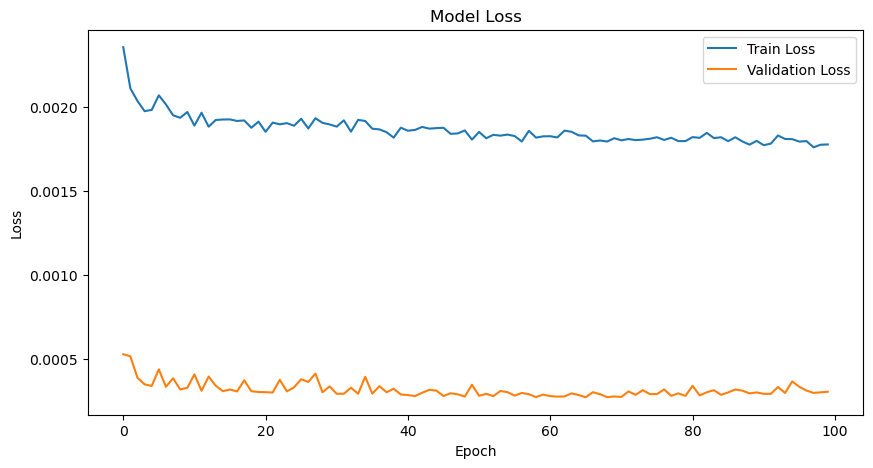

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Load your DataFrame (ensure this path is correct)
# df = pd.read_csv('your_file.csv')  # Uncomment and replace with your actual file path

# Clean column names if necessary
df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace

# Convert 'Date' column to datetime format and sort values
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Print available columns for debugging
print("Available columns:", df.columns)

# Define required features and check for their presence
required_features = ['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    required_features.append('rain')
if 'season' in df.columns:
    required_features.append('season')

# Select relevant features and drop rows with NaN values
df = df[required_features].dropna()

# One-hot encode the 'season' column if it exists
if 'season' in df.columns:
    encoder = OneHotEncoder(sparse_output=False)
    season_encoded = encoder.fit_transform(df[['season']])
    
    # Combine encoded seasons with the DataFrame
    df_encoded = pd.concat([df.drop(columns=['season']), pd.DataFrame(season_encoded)], axis=1)
else:
    df_encoded = df.copy()  # No encoding needed if season is absent

# Normalize the numerical features
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_encoded[['minimum price/kg', 'maximum price/kg', 'modal price/kg'] + (['rain'] if 'rain' in df.columns else [])])

# Create a DataFrame with scaled prices and encoded seasons (if any)
columns_list = ['minimum price/kg', 'maximum price/kg', 'modal price/kg']
if 'rain' in df.columns:
    columns_list.append('rain')
if 'season' in df.columns:
    columns_list += list(encoder.get_feature_names_out())

scaled_df = pd.DataFrame(scaled_prices, columns=columns_list[:scaled_prices.shape[1]])
scaled_df['Date'] = df['Date'].values[:scaled_df.shape[0]]  # Ensure Date aligns correctly

# Set Date as index
scaled_df.set_index('Date', inplace=True)

# Create sequences for LSTM input (X) and output (y)
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 2])  # Assuming modal price is the target variable
    return np.array(X), np.array(y)

# Define time steps (number of previous days to consider)
time_steps = 30  # Using past 30 days to predict the next day

X, y = create_sequences(scaled_prices, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model using Input layer instead of input_shape in LSTM layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Use Input layer to specify input shape
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile the model with Mean Squared Error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 0.0044 - val_loss: 6.5162e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0057 - val_loss: 3.8084e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.4205e-04 - val_loss: 3.5051e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0023 - val_loss: 3.5734e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0013 - val_loss: 3.3124e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - val_loss: 3.6701e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.7860e-04 - val_loss: 3.9175e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0029 - val_loss: 3.3834e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0023 - val_loss: 3.2824e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 8.8642e-04 - val_loss: 3.7056e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.6220e-04 - val_loss: 4

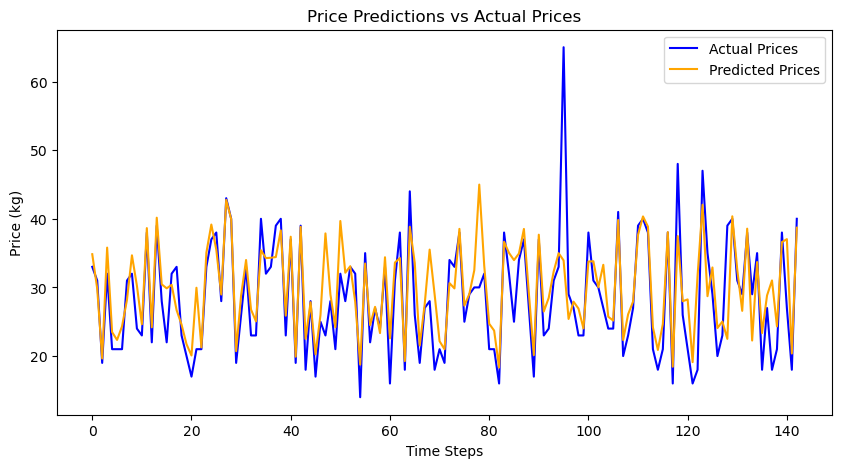

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt

# Load your CSV data
 # Replace with your actual CSV file path

# Ensure 'Date' is in datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Select relevant features and drop rows with NaN values
features = ['Date', 'minimum price/kg', 'maximum price/kg', 'modal price/kg']
df = df[features].dropna()

# Normalize the price data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['minimum price/kg', 'maximum price/kg', 'modal price/kg']])

# Create a DataFrame with scaled prices
scaled_df = pd.DataFrame(scaled_prices, columns=['minimum price/kg', 'maximum price/kg', 'modal price/kg'])
scaled_df['Date'] = df['Date'].values

# Set Date as index
scaled_df.set_index('Date', inplace=True)

# Create sequences for LSTM input (X) and output (y)
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 2])  # Assuming modal price is the target variable
    return np.array(X), np.array(y)

# Define time steps (number of previous days to consider)
time_steps = 30  # For example, using past 30 days to predict the next day

X, y = create_sequences(scaled_prices, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model using Input layer instead of input_shape in LSTM layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Use Input layer to specify input shape
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile the model with Mean Squared Error loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions on test set
predictions = model.predict(X_test)

# Inverse transform predictions and actual values for comparison
predictions_inverse = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 2)), predictions), axis=1))[:, 2]
y_test_inverse = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 2)), y_test.reshape(-1, 1)), axis=1))[:, 2]

# Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse, label='Actual Prices', color='blue')
plt.plot(predictions_inverse, label='Predicted Prices', color='orange')
plt.title('Price Predictions vs Actual Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price (kg)')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
        Date  Predicted Price
0 2024-11-07        28.640197
1 2024-11-08        21.427032
2 2024-11-09        16.393900
3 2024-11-10        13.390676
4 2024-11-11        11.638955
5 2024-11-12        10.559900
6 2024-11-13         9.810848


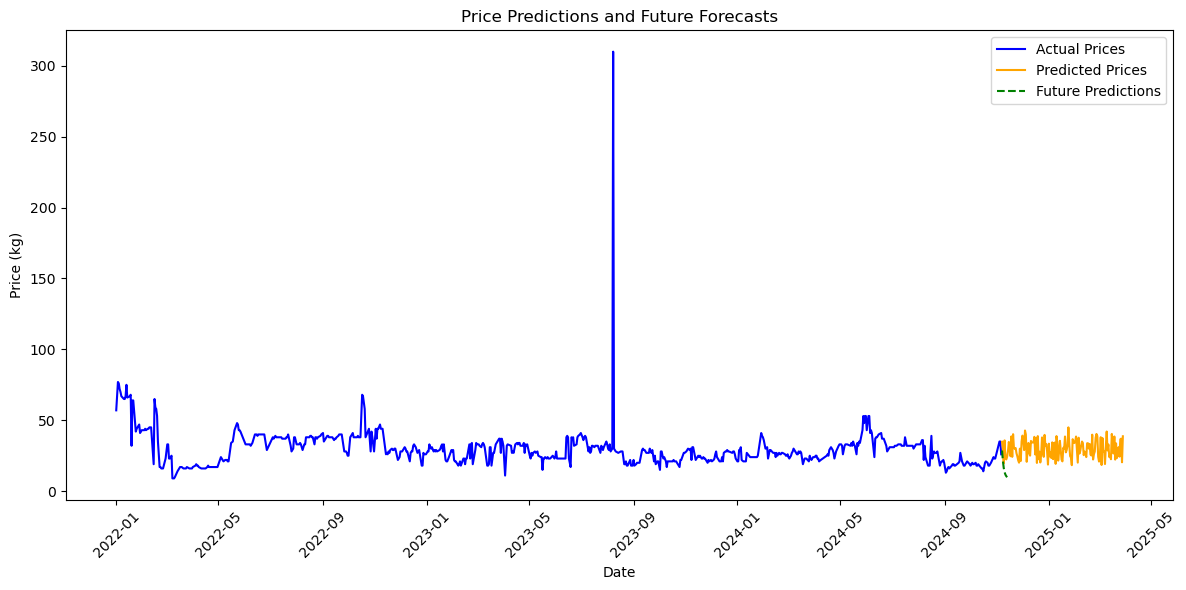

In [21]:
# Prepare for future predictions
last_sequence = scaled_prices[-time_steps:]  # Get last sequence from scaled prices
future_predictions = []

# Predicting prices for the next week (7 days)
for _ in range(7):
    last_sequence_reshaped = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))
    next_price = model.predict(last_sequence_reshaped)
    
    # Append predicted price (flattened)
    future_predictions.append(next_price[0][0])  
    
    # Update last_sequence with new prediction (shift window)
    # Ensure next_price is reshaped correctly
    last_sequence = np.append(last_sequence[1:], [[next_price[0][0], next_price[0][0], next_price[0][0]]], axis=0)

# Inverse transform future predictions to original scale
future_predictions_inverse = scaler.inverse_transform(np.concatenate((np.zeros((len(future_predictions), 2)), np.array(future_predictions).reshape(-1, 1)), axis=1))[:, 2]

# Create a DataFrame for future predictions
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)  # Next week dates
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions_inverse})

# Display results in table format
print(future_df)

# Plotting actual vs predicted prices along with future predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['modal price/kg'], label='Actual Prices', color='blue')
plt.plot(pd.date_range(start=df['Date'].iloc[-len(predictions):].values[-1] + pd.Timedelta(days=1), periods=len(predictions)),
         predictions_inverse,
         label='Predicted Prices', color='orange')
plt.plot(future_df['Date'], future_df['Predicted Price'], label='Future Predictions', color='green', linestyle='--')
plt.title('Price Predictions and Future Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (kg)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Inverse transform predictions and actual values for comparison
num_features = scaled_prices.shape[1]  # Get number of features used in scaling

predictions_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], num_features - 1)), predictions), axis=1)
)[:, 2]

y_test_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], num_features - 1)), y_test.reshape(-1, 1)), axis=1)
)[:, 2]

# Calculate accuracy metrics: MAE, RMSE, and R² score
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
r2 = r2_score(y_test_inverse, predictions_inverse)

# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}') 

Mean Absolute Error (MAE): 3.394767498180687
Root Mean Squared Error (RMSE): 5.165726646511397
R-squared (R²): 0.612980316734788


In [23]:
# Make predictions on test set# Define a function to calculate accuracy based on a threshold
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    # Calculate the absolute percentage error
    abs_percentage_error = np.abs((y_true - y_pred) / y_true)
    # Count how many predictions are within the threshold
    accurate_predictions = np.sum(abs_percentage_error < threshold)
    # Calculate accuracy as a percentage
    accuracy = accurate_predictions / len(y_true) * 100
    return accuracy

# Inverse transform predictions and actual values for comparison
num_features = scaled_prices.shape[1]  # Get number of features used in scaling

predictions_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], num_features - 1)), predictions), axis=1)
)[:, 2]

y_test_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], num_features - 1)), y_test.reshape(-1, 1)), axis=1)
)[:, 2]

# Calculate accuracy with a defined threshold (e.g., 10% error)
accuracy = calculate_accuracy(y_test_inverse, predictions_inverse, threshold=0.1)

# Print the calculated accuracy
print(f'Accuracy of Predictions: {accuracy:.2f}%')

Accuracy of Predictions: 55.94%


In [36]:
import sklearn
print(sklearn.__version__)

1.2.2


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [40]:
data_to_save = {
    'model': model,
    'future_predictions': future_predictions_inverse,
    'future_df': future_df
}

# Save to a pickle file
with open('finalbeetroot_price_predictions.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Pickle file created successfully.")

Pickle file created successfully.
